# Denoising Internet Delay measurements using Snorkel

In this notebook we will be using `Snorkel` which provides a framework for <i>`weakly supervised learning`</i> technique, for identifying the possible noise in the internet delay measurements. The basic idea of Snorkel is data programming paradigm, in which the we create a set of labeling functions, which are just scripts that programmatically label data. The resulting labels are noisy, but Snorkel automatically models this process by learning the labeling functions and then uses this to train a deep neural network.

In [2]:
import os
from snorkel import SnorkelSession
session = SnorkelSession()

In [3]:
from snorkel.parser import TSVDocPreprocessor
    
doc_preprocessor = TSVDocPreprocessor('/users/anirudhmuthukumar/downloads/snorkel-master/myscripts/data/Format-5 RTT.tsv')

In [4]:
from snorkel.parser.spacy_parser import Spacy
from snorkel.parser import CorpusParser

corpus_parser = CorpusParser(parser=Spacy())
%time c = corpus_parser.apply(doc_preprocessor)

Clearing existing...
Running UDF...
CPU times: user 38.4 s, sys: 1.06 s, total: 39.5 s
Wall time: 42.7 s


In [5]:
from snorkel.models import Document, Sentence

print("Documents:", session.query(Document).count())
print("Sentences:", session.query(Sentence).count())

('Documents:', 26323)
('Sentences:', 26323)


## Splitting the dataset into three sets 

In [6]:
docs = session.query(Document).order_by(Document.name).all()

train_sents = set()
dev_sents   = set()
test_sents  = set()

for i, doc in enumerate(docs):
    for s in doc.sentences:
            if i % 201 == 9:
                dev_sents.add(s)
            elif i % 27 == 8:
                test_sents.add(s)
            else:
                train_sents.add(s)
                
len(dev_sents), len(train_sents), len(test_sents)

(131, 25217, 975)

Sample format of the sentences 

In [7]:
session.query(Sentence).all()

[Sentence(Document 1,0,260.0 260.0
 ), Sentence(Document 2,0,260.0 260.0
 ), Sentence(Document 3,0,260.0 260.0
 ), Sentence(Document 4,0,131.0 131.0
 ), Sentence(Document 5,0,366.0 366.0
 ), Sentence(Document 6,0,258.0 258.0
 ), Sentence(Document 7,0,270.0 270.0
 ), Sentence(Document 8,0,282.0 282.0
 ), Sentence(Document 9,0,278.0 278.0
 ), Sentence(Document 10,0,278.0 278.0
 ), Sentence(Document 11,0,284.0 284.0
 ), Sentence(Document 12,0,260.0 260.0
 ), Sentence(Document 13,0,254.0 254.0
 ), Sentence(Document 14,0,132.0 132.0
 ), Sentence(Document 15,0,284.0 284.0
 ), Sentence(Document 16,0,86000.0 86000.0
 ), Sentence(Document 17,0,262.0 262.0
 ), Sentence(Document 18,0,297.0 297.0
 ), Sentence(Document 19,0,246.0 246.0
 ), Sentence(Document 20,0,254.0 254.0
 ), Sentence(Document 21,0,261.0 261.0
 ), Sentence(Document 22,0,254.0 254.0
 ), Sentence(Document 23,0,221000.0 221000.0
 ), Sentence(Document 24,0,276.0 276.0
 ), Sentence(Document 25,0,288.00000000000006 288.00000000000006
 

### Defining candidate subclass 
`Candidates` are basically potential mentions found in text in which we are interested in for training the model.

In [8]:
from snorkel.models import candidate_subclass

Person = candidate_subclass('Person', ['person'])
Number = candidate_subclass('learning', ['number1', 'number2'])

In [9]:
from snorkel.candidates import Ngrams, CandidateExtractor
from snorkel.matchers import RegexMatchEach

ngrams         = Ngrams(n_max=1)
string_matcher = RegexMatchEach(rgx='^[A]+$')
number_matcher = RegexMatchEach(rgx='^[0-9]+.[0-9]+$')
cand_extractor = CandidateExtractor(Number, [ngrams, ngrams], [number_matcher, number_matcher])

### Applying `CandidateExtractor` to three sets of data

In [10]:
for i, sents in enumerate([train_sents, dev_sents, test_sents]):
    %time cand_extractor.apply(sents, split=i)
    print("Number of candidates:", session.query(Number).filter(Number.split == i).count())

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 1min 6s, sys: 768 ms, total: 1min 7s
Wall time: 1min 7s
('Number of candidates:', 25217)
Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 592 ms, sys: 59 ms, total: 651 ms
Wall time: 690 ms
('Number of candidates:', 131)
Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 3.12 s, sys: 127 ms, total: 3.24 s
Wall time: 3.34 s
('Number of candidates:', 975)


In [11]:
train_cands = session.query(Number).filter(Number.split == 0).all()
dev_cands = session.query(Number).filter(Number.split == 1).all()
test_cands = session.query(Number).filter(Number.split == 2).all()

In [12]:
train_cands[:3]

[learning(Span("280.0", sentence=43034, chars=[0,4], words=[0,0]), Span("280.0", sentence=43034, chars=[6,10], words=[1,1])),
 learning(Span("277.0", sentence=50380, chars=[0,4], words=[0,0]), Span("277.0", sentence=50380, chars=[6,10], words=[1,1])),
 learning(Span("133.0", sentence=51295, chars=[0,4], words=[0,0]), Span("133.0", sentence=51295, chars=[6,10], words=[1,1]))]

In [24]:
def Bad_Measurement(c):
    val = c.number1.get_attrib_tokens()
    if float(val[0])>=435:
        return 1
    else:
        return 0

In [25]:
LFs = [ LF_Good_Measurement] 

## Percentage of noise in each set 

In [26]:
labeled = []
for c in train_cands:
    if Bad_Measurement(c) != 0:
        labeled.append(c)
t = len(labeled)
f = len(train_cands)

print("Percentage of noise in training set : " + str(float(t*1.0/f)*100) )

Percentage of noise in training set : 9.97739620098


In [27]:
labeled = []
for c in dev_cands:
    if Bad_Measurement(c) != 0:
        labeled.append(c)
t = len(labeled)
f = len(dev_cands)

print("Percentage of noise in development set : " + str(float(t*1.0/f)*100) )

Percentage of noise in development set : 10.6870229008


In [204]:
labeled = []
for c in test_cands:
    if Bad_Measurement(c) != 0:
        labeled.append(c)
t = len(labeled)
f = len(test_cands)

print("Percentage of noise in test set : " + str(float(t*1.0/f)*100), str(t) )

('Percentage of noise in test set : 10.5641025641', '103')


## Annotating dev set 

In [29]:
from snorkel.viewer import SentenceNgramViewer

#Lab value = 435
SentenceNgramViewer(dev_cands, session, n_per_page=1)

<IPython.core.display.Javascript object>

U2VudGVuY2VOZ3JhbVZpZXdlcihjaWRzPVtbWzU4XV0sIFtbMjBdXSwgW1sxMl1dLCBbWzk1XV0sIFtbMjRdXSwgW1s1Ml1dLCBbWzc0XV0sIFtbNjJdXSwgW1szN11dLCBbWzJdXSwgW1sxMjPigKY=


### Loading the annotated dev set 

In [30]:
from snorkel.annotations import load_gold_labels
L_gold_dev = load_gold_labels(session, annotator_name=os.environ['USER'], split=1)
L_gold_dev

<131x1 sparse matrix of type '<type 'numpy.int64'>'
	with 131 stored elements in Compressed Sparse Row format>

## Annotating test set 

In [203]:
from snorkel.viewer import SentenceNgramViewer

#Lab value = 435
SentenceNgramViewer(test_cands, session, n_per_page=1)

<IPython.core.display.Javascript object>

U2VudGVuY2VOZ3JhbVZpZXdlcihjaWRzPVtbWzExMF1dLCBbWzg3NF1dLCBbWzQwMl1dLCBbWzk3NF1dLCBbWzE5Nl1dLCBbWzQ1Ml1dLCBbWzYxMF1dLCBbWzk0XV0sIFtbNTAxXV0sIFtbNzPigKY=


In [36]:
L_gold_test = load_gold_labels(session, annotator_name=os.environ['USER'], split=2)
L_gold_test

<975x1 sparse matrix of type '<type 'numpy.int64'>'
	with 975 stored elements in Compressed Sparse Row format>

## Heuristics for assigning probabilities to outliers 

In [433]:
def badness(value):
    if value<=5:
        return 0.45
    elif value<=10:
        return 0.40
    elif value<=15:
        return 0.35
    elif value<=20:
        return 0.30
    elif value<=25:
        return 0.25
    elif value<=30:
        return 0.20
    elif value<=50:
        return 0.15
    elif value<=100:
        return 0.10
    else:
        return 0.01

# 1. KMeans Clustering

### Defining labelling function 

In [275]:
def LF_Good_Measurement1(c):
    val = c.number1.get_attrib_tokens()
    if float(val[0])<=304.8:
        return 1
    else:
        return 0
LFs = [ LF_Good_Measurement1 ]

In [276]:
from snorkel.annotations import LabelAnnotator
import numpy as np

labeler1 = LabelAnnotator(lfs=LFs)

np.random.seed(1701)
%time L_train1 = labeler1.apply(split=0)
L_train1

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 1min 18s, sys: 475 ms, total: 1min 18s
Wall time: 1min 18s


<25217x1 sparse matrix of type '<type 'numpy.int64'>'
	with 22359 stored elements in Compressed Sparse Row format>

In [39]:
L_train1.lf_stats(session)

j  Coverage  Overlaps  Conflicts
LF_Good_Measurement  0  0.886664       0.0        0.0

In [40]:
L_train1.get_candidate(session, 0)

learning(Span("259.0", sentence=41465, chars=[0,4], words=[0,0]), Span("259.0", sentence=41465, chars=[6,10], words=[1,1]))

In [41]:
np.random.seed(1701)

%time L_dev1 = labeler1.apply_existing(split=1, lfs=LFs, parallelism=1)
print L_dev1.shape
L_dev1

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 828 ms, sys: 41.4 ms, total: 869 ms
Wall time: 911 ms
(131, 1)


<131x1 sparse matrix of type '<type 'numpy.int64'>'
	with 113 stored elements in Compressed Sparse Row format>

In [42]:
L_dev1.lf_stats(session, labels=L_gold_dev.toarray().ravel())

j  Coverage  Overlaps  Conflicts   TP  FP  FN  TN  \
LF_Good_Measurement  0  0.862595       0.0        0.0  113   0   0   0   

                     Empirical Acc.  
LF_Good_Measurement             1.0

## Gen model 

In [44]:
from snorkel.learning import GenerativeModel

gen_model1 = GenerativeModel()
gen_model1.train(L_train1, epochs=100, decay=0.95, step_size=0.1 / L_train1.shape[0], reg_param=1e-6)

Inferred cardinality: 2


In [45]:
gen_model1.weights.lf_accuracy

array([1.34191283])

In [483]:
train_marginals1 = gen_model1.marginals(L_train1)
train_marginals1

array([0.93606546, 0.93606546, 0.93606546, ..., 0.93606546, 0.93606546,
       0.93606546])

#### Assigning probabilities to noisy data 

In [484]:
temp1 = train_marginals1

val = 304.8
for i in range(len(train_marginals1)):
    if train_marginals1[i]==0.5:
        diff = float(train_cands[i].number1.get_attrib_tokens()[0])-val
        #print(diff)
        temp1[i] = badness(diff)

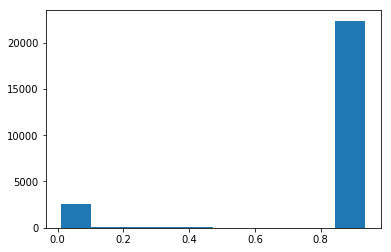

In [485]:
import matplotlib.pyplot as plt
plt.hist(train_marginals1)
plt.show()

In [486]:
gen_model1.learned_lf_stats()

Accuracy  Coverage  Precision   Recall
0  0.938148    0.8003   0.939945  0.74634

### Evaluating Generative model

In [49]:
L_dev1 = labeler.apply_existing(split=1)

Clearing existing...
Running UDF...
[========================================] 100%



In [50]:
tp, fp, tn, fn = gen_model1.error_analysis(session, L_dev1, L_gold_dev)

Scores (Un-adjusted)
Pos. class accuracy: 0.966
Neg. class accuracy: 1.0
Precision            1.0
Recall               0.966
F1                   0.983
----------------------------------------
TP: 113 | FP: 0 | TN: 14 | FN: 4



#### Accuracy = (113+14) / ( 113+14+4+0)
         = <b>96.94%<b>

### Discriminative model 

In [487]:
from snorkel.learning.disc_models.rnn import reRNN

train_kwargs = {
    'lr':         0.001,
    'dim':        100,
    'n_epochs':   10,
    'dropout':    0.25,
    'print_freq': 1,
    'batch_size': 128,
    'max_sentence_length': 100
}

lstm1 = reRNN(seed=1701, n_threads=2)
%time lstm1.train(train_cands, train_marginals1, X_dev=dev_cands, Y_dev=L_gold_dev, **train_kwargs)

[reRNN] Training model
[reRNN] n_train=25217  #epochs=10  batch size=128
[reRNN] Epoch 0 (42.96s)	Average loss=0.322642	Dev F1=97.82
[reRNN] Epoch 1 (84.37s)	Average loss=0.226914	Dev F1=98.70
[reRNN] Epoch 2 (124.94s)	Average loss=0.224461	Dev F1=99.57
[reRNN] Epoch 3 (161.96s)	Average loss=0.223837	Dev F1=98.26
[reRNN] Epoch 4 (203.36s)	Average loss=0.223643	Dev F1=97.82
[reRNN] Epoch 5 (246.97s)	Average loss=0.223507	Dev F1=97.82
[reRNN] Epoch 6 (286.00s)	Average loss=0.223570	Dev F1=97.82
[reRNN] Epoch 7 (328.93s)	Average loss=0.223483	Dev F1=98.26
[reRNN] Epoch 8 (366.05s)	Average loss=0.223463	Dev F1=97.82
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 9 (403.93s)	Average loss=0.223391	Dev F1=97.82
[reRNN] Training done (404.03s)
INFO:tensorflow:Restoring parameters from checkpoints/reRNN/reRNN-8
[reRNN] Loaded model <reRNN>
CPU times: user 13min 3s, sys: 43.7 s, total: 13min 47s
Wall time: 6min 50s


### Precision on test candidates  

In [488]:
p, r, f1 = lstm1.score(test_cands, L_gold_test)
print("Prec: {0:.3f}, Recall: {1:.3f}, F1 Score: {2:.3f}".format(p, r, f1))

Prec: 1.000, Recall: 0.981, F1 Score: 0.990


In [489]:
tp, fp, tn, fn = lstm1.error_analysis(session, test_cands, L_gold_test)

Scores (Un-adjusted)
Pos. class accuracy: 0.981
Neg. class accuracy: 1.0
Precision            1.0
Recall               0.981
F1                   0.99
----------------------------------------
TP: 855 | FP: 0 | TN: 103 | FN: 17



### Saving the LSTM model 

In [530]:
lstm1.save("LSTM1")

[reRNN] Model saved as <LSTM1>


# 2. Hierarchical Clustering 

In [56]:
def LF_Good_Measurement2(c):
    val = c.number1.get_attrib_tokens()
    if float(val[0])<=283.7:
        return 1
    else:
        return 0
LFs2 = [ LF_Good_Measurement2] 

#### Applying labelling function to the train set

In [57]:
from snorkel.annotations import LabelAnnotator
import numpy as np

labeler2 = LabelAnnotator(lfs=LFs2)

np.random.seed(1701)
%time L_train2 = labeler2.apply(split=0)
L_train2

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 1min 22s, sys: 1.1 s, total: 1min 23s
Wall time: 1min 24s


<25217x1 sparse matrix of type '<type 'numpy.int64'>'
	with 18971 stored elements in Compressed Sparse Row format>

In [58]:
L_train2.lf_stats(session)

j  Coverage  Overlaps  Conflicts
LF_Good_Measurement2  0   0.75231       0.0        0.0

#### Applying labelling function to dev set

In [59]:
np.random.seed(1701)

%time L_dev2 = labeler2.apply_existing(split=1, lfs=LFs2, parallelism=1)
print L_dev2.shape
L_dev2

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 944 ms, sys: 40.9 ms, total: 984 ms
Wall time: 1.1 s
(131, 1)


<131x1 sparse matrix of type '<type 'numpy.int64'>'
	with 101 stored elements in Compressed Sparse Row format>

In [60]:
L_dev2.lf_stats(session, labels=L_gold_dev.toarray().ravel())

j  Coverage  Overlaps  Conflicts   TP  FP  FN  TN  \
LF_Good_Measurement2  0  0.770992       0.0        0.0  101   0   0   0   

                      Empirical Acc.  
LF_Good_Measurement2             1.0

#### Training Generative Model 

In [61]:
from snorkel.learning import GenerativeModel

gen_model2 = GenerativeModel()
gen_model2.train(L_train2, epochs=100, decay=0.95, step_size=0.1 / L_train2.shape[0], reg_param=1e-6)

Inferred cardinality: 2


In [62]:
gen_model2.weights.lf_accuracy

array([0.99165263])

In [63]:
train_marginals2 = gen_model2.marginals(L_train2)
train_marginals2

array([0.87903306, 0.5       , 0.87903306, ..., 0.87903306, 0.87903306,
       0.87903306])

#### Assigning probabilities to noisy data 

In [490]:
temp2 = train_marginals2

val = 283.7
for i in range(len(train_marginals2)):
    if train_marginals2[i]==0.5:
        diff = float(train_cands[i].number1.get_attrib_tokens()[0])-val
        #print(diff)
        temp2[i] = badness(diff)

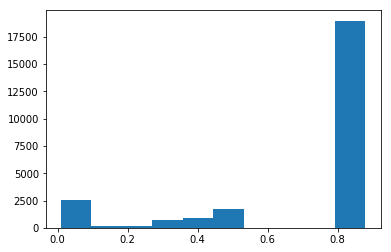

In [491]:
import matplotlib.pyplot as plt
plt.hist(train_marginals2)
plt.show()

In [65]:
gen_model2.learned_lf_stats()

Accuracy  Coverage  Precision    Recall
0  0.873073    0.7524    0.87026  0.649091

#### Evaluating Generative model

In [66]:
L_dev2 = labeler2.apply_existing(split=1)

Clearing existing...
Running UDF...
[========================================] 100%



In [67]:
tp, fp, tn, fn = gen_model2.error_analysis(session, L_dev2, L_gold_dev)

Scores (Un-adjusted)
Pos. class accuracy: 0.863
Neg. class accuracy: 1.0
Precision            1.0
Recall               0.863
F1                   0.927
----------------------------------------
TP: 101 | FP: 0 | TN: 14 | FN: 16



Accuracy = (104+4)/(104+4+24+0) = <b>81.81%</b>

#### Discriminative model 

In [492]:
from snorkel.learning.disc_models.rnn import reRNN

train_kwargs = {
    'lr':         0.001,
    'dim':        100,
    'n_epochs':   10,
    'dropout':    0.25,
    'print_freq': 1,
    'batch_size': 128,
    'max_sentence_length': 100
}

lstm2 = reRNN(seed=1701, n_threads=2)
%time lstm2.train(train_cands, train_marginals2, X_dev=dev_cands, Y_dev=L_gold_dev, **train_kwargs)

[reRNN] Training model
[reRNN] n_train=25217  #epochs=10  batch size=128
[reRNN] Epoch 0 (42.60s)	Average loss=0.454274	Dev F1=92.17
[reRNN] Epoch 1 (81.89s)	Average loss=0.381669	Dev F1=92.17
[reRNN] Epoch 2 (120.36s)	Average loss=0.379227	Dev F1=92.17
[reRNN] Epoch 3 (163.60s)	Average loss=0.378672	Dev F1=92.17
[reRNN] Epoch 4 (205.03s)	Average loss=0.378714	Dev F1=92.17
[reRNN] Epoch 5 (247.64s)	Average loss=0.378572	Dev F1=92.17
[reRNN] Epoch 6 (290.09s)	Average loss=0.378594	Dev F1=92.17
[reRNN] Epoch 7 (333.53s)	Average loss=0.378534	Dev F1=92.17
[reRNN] Epoch 8 (376.39s)	Average loss=0.378503	Dev F1=92.17
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 9 (418.84s)	Average loss=0.378505	Dev F1=92.17
[reRNN] Training done (418.93s)
INFO:tensorflow:Restoring parameters from checkpoints/reRNN/reRNN-8
[reRNN] Loaded model <reRNN>
CPU times: user 13min 27s, sys: 46.2 s, total: 14min 13s
Wall time: 7min 4s


#### Evaluating Discriminative model 

In [493]:
p, r, f1 = lstm2.score(test_cands, L_gold_test)
print("Prec: {0:.3f}, Recall: {1:.3f}, F1 Score: {2:.3f}".format(p, r, f1))

Prec: 1.000, Recall: 0.846, F1 Score: 0.917


In [494]:
tp, fp, tn, fn = lstm2.error_analysis(session, test_cands, L_gold_test)

Scores (Un-adjusted)
Pos. class accuracy: 0.846
Neg. class accuracy: 1.0
Precision            1.0
Recall               0.846
F1                   0.917
----------------------------------------
TP: 738 | FP: 0 | TN: 103 | FN: 134



### Saving the LSTM model 

In [529]:
lstm2.save("LSTM2")

[reRNN] Model saved as <LSTM2>


# 3. Mean Analysis 

In [71]:
def LF_Good_Measurement3(c):
    val = c.number1.get_attrib_tokens()
    if float(val[0])<=266.9:
        return 1
    else:
        return 0
LFs3 = [ LF_Good_Measurement3] 

#### Applying labelling function to the train set

In [72]:
from snorkel.annotations import LabelAnnotator
import numpy as np

labeler3 = LabelAnnotator(lfs=LFs3)

np.random.seed(1701)
%time L_train3 = labeler3.apply(split=0)
L_train3

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 1min 16s, sys: 547 ms, total: 1min 17s
Wall time: 1min 17s


<25217x1 sparse matrix of type '<type 'numpy.int64'>'
	with 9079 stored elements in Compressed Sparse Row format>

In [73]:
L_train3.lf_stats(session)

j  Coverage  Overlaps  Conflicts
LF_Good_Measurement3  0  0.360035       0.0        0.0

#### Applying labelling function to dev set

In [74]:
np.random.seed(1701)

%time L_dev3 = labeler3.apply_existing(split=1, lfs=LFs3, parallelism=1)
print L_dev3.shape
L_dev3

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 756 ms, sys: 41.4 ms, total: 797 ms
Wall time: 836 ms
(131, 1)


<131x1 sparse matrix of type '<type 'numpy.int64'>'
	with 42 stored elements in Compressed Sparse Row format>

In [75]:
L_dev3.lf_stats(session, labels=L_gold_dev.toarray().ravel())

j  Coverage  Overlaps  Conflicts  TP  FP  FN  TN  \
LF_Good_Measurement3  0  0.320611       0.0        0.0  42   0   0   0   

                      Empirical Acc.  
LF_Good_Measurement3             1.0

#### Training Generative Model 

In [76]:
from snorkel.learning import GenerativeModel

gen_model3 = GenerativeModel()
gen_model3.train(L_train3, epochs=100, decay=0.95, step_size=0.1 / L_train3.shape[0], reg_param=1e-6)

Inferred cardinality: 2


In [77]:
gen_model3.weights.lf_accuracy

array([0.29837205])

In [78]:
train_marginals3 = gen_model3.marginals(L_train3)
train_marginals3

array([0.64491106, 0.5       , 0.5       , ..., 0.5       , 0.5       ,
       0.5       ])

#### Assigning probabilities to noisy data 

In [495]:
temp3 = train_marginals3

val = 266.9
for i in range(len(train_marginals3)):
    if train_marginals3[i]==0.5:
        diff = float(train_cands[i].number1.get_attrib_tokens()[0])-val
        #print(diff)
        temp3[i] = badness(diff)

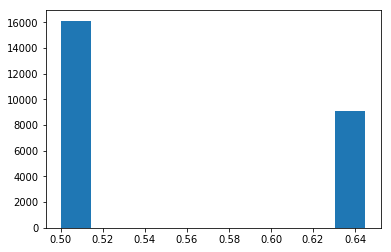

In [79]:
import matplotlib.pyplot as plt
plt.hist(train_marginals3)
plt.show()

In [80]:
gen_model3.learned_lf_stats()

Accuracy  Coverage  Precision    Recall
0  0.639929    0.6732   0.637677  0.417925

#### Evaluating Generative model

In [81]:
L_dev3 = labeler3.apply_existing(split=1)

Clearing existing...
Running UDF...
[========================================] 100%



In [82]:
tp, fp, tn, fn = gen_model3.error_analysis(session, L_dev3, L_gold_dev)

Scores (Un-adjusted)
Pos. class accuracy: 0.359
Neg. class accuracy: 1.0
Precision            1.0
Recall               0.359
F1                   0.528
----------------------------------------
TP: 42 | FP: 0 | TN: 14 | FN: 75



Accuracy = (55+4)/(55+4+73+0) = <b>44.69%</b>

#### Discriminative model 

In [496]:
from snorkel.learning.disc_models.rnn import reRNN

train_kwargs = {
    'lr':         0.001,
    'dim':        100,
    'n_epochs':   10,
    'dropout':    0.25,
    'print_freq': 1,
    'batch_size': 128,
    'max_sentence_length': 100
}

lstm3 = reRNN(seed=1701, n_threads=2)
%time lstm3.train(train_cands, train_marginals3, X_dev=dev_cands, Y_dev=L_gold_dev, **train_kwargs)

[reRNN] Training model
[reRNN] n_train=25217  #epochs=10  batch size=128
[reRNN] Epoch 0 (42.03s)	Average loss=0.605457	Dev F1=51.90
[reRNN] Epoch 1 (83.62s)	Average loss=0.580889	Dev F1=51.90
[reRNN] Epoch 2 (121.98s)	Average loss=0.580182	Dev F1=51.90
[reRNN] Epoch 3 (162.34s)	Average loss=0.579850	Dev F1=51.90
[reRNN] Epoch 4 (199.83s)	Average loss=0.579738	Dev F1=51.90
[reRNN] Epoch 5 (236.88s)	Average loss=0.579799	Dev F1=51.90
[reRNN] Epoch 6 (275.20s)	Average loss=0.579692	Dev F1=51.90
[reRNN] Epoch 7 (313.52s)	Average loss=0.579705	Dev F1=51.90
[reRNN] Epoch 8 (351.23s)	Average loss=0.579675	Dev F1=51.90
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 9 (388.95s)	Average loss=0.579695	Dev F1=51.90
[reRNN] Training done (389.05s)
INFO:tensorflow:Restoring parameters from checkpoints/reRNN/reRNN-8
[reRNN] Loaded model <reRNN>
CPU times: user 12min 43s, sys: 40.7 s, total: 13min 23s
Wall time: 6min 34s


#### Evaluating Discriminative model 

In [497]:
p, r, f1 = lstm3.score(test_cands, L_gold_test)
print("Prec: {0:.3f}, Recall: {1:.3f}, F1 Score: {2:.3f}".format(p, r, f1))

Prec: 1.000, Recall: 0.414, F1 Score: 0.586


In [498]:
tp, fp, tn, fn = lstm3.error_analysis(session, test_cands, L_gold_test)

Scores (Un-adjusted)
Pos. class accuracy: 0.414
Neg. class accuracy: 1.0
Precision            1.0
Recall               0.414
F1                   0.586
----------------------------------------
TP: 361 | FP: 0 | TN: 103 | FN: 511



### Saving the LSTM model 

In [528]:
lstm3.save("LSTM3")

[reRNN] Model saved as <LSTM3>


# 4. Mean + SD 

In [86]:
def LF_Good_Measurement4(c):
    val = c.number1.get_attrib_tokens()
    if float(val[0])<=277.9:
        return 1
    else:
        return 0
LFs4 = [ LF_Good_Measurement4] 

In [87]:
from snorkel.annotations import LabelAnnotator
import numpy as np

labeler4 = LabelAnnotator(lfs=LFs4)

#### Applying labelling function to the train set

In [88]:
np.random.seed(1701)
%time L_train4 = labeler4.apply(split=0)
L_train4

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 1min 22s, sys: 773 ms, total: 1min 23s
Wall time: 1min 24s


<25217x1 sparse matrix of type '<type 'numpy.int64'>'
	with 16157 stored elements in Compressed Sparse Row format>

In [89]:
L_train4.lf_stats(session)

j  Coverage  Overlaps  Conflicts
LF_Good_Measurement4  0  0.640719       0.0        0.0

#### Applying labelling function to dev set

In [90]:
np.random.seed(1701)

%time L_dev4 = labeler4.apply_existing(split=1, lfs=LFs4, parallelism=1)
print L_dev4.shape
L_dev4

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 822 ms, sys: 42.8 ms, total: 865 ms
Wall time: 919 ms
(131, 1)


<131x1 sparse matrix of type '<type 'numpy.int64'>'
	with 89 stored elements in Compressed Sparse Row format>

In [91]:
L_dev4.lf_stats(session, labels=L_gold_dev.toarray().ravel())

j  Coverage  Overlaps  Conflicts  TP  FP  FN  TN  \
LF_Good_Measurement4  0  0.679389       0.0        0.0  89   0   0   0   

                      Empirical Acc.  
LF_Good_Measurement4             1.0

#### Training Generative Model 

In [92]:
from snorkel.learning import GenerativeModel

gen_model4 = GenerativeModel()
gen_model4.train(L_train4, epochs=100, decay=0.95, step_size=0.1 / L_train4.shape[0], reg_param=1e-6)

Inferred cardinality: 2


In [93]:
gen_model4.weights.lf_accuracy

array([0.73949081])

In [94]:
train_marginals4 = gen_model4.marginals(L_train4)
train_marginals4

array([0.81441871, 0.5       , 0.81441871, ..., 0.81441871, 0.81441871,
       0.81441871])

#### Assigning probabilities to noisy data 

In [502]:
temp4 = train_marginals4

val = 277.9
for i in range(len(train_marginals4)):
    if train_marginals4[i]==0.5:
        diff = float(train_cands[i].number1.get_attrib_tokens()[0])-val
        #print(diff)
        temp4[i] = badness(diff)

In [503]:
import matplotlib.pyplot as plt
plt.hist(train_marginals4)
plt.show()

In [96]:
gen_model4.learned_lf_stats()

Accuracy  Coverage  Precision    Recall
0  0.811342    0.7177    0.81035  0.574713

#### Evaluating Generative model

In [98]:
tp, fp, tn, fn = gen_model4.error_analysis(session, L_dev4, L_gold_dev)

Scores (Un-adjusted)
Pos. class accuracy: 0.761
Neg. class accuracy: 1.0
Precision            1.0
Recall               0.761
F1                   0.864
----------------------------------------
TP: 89 | FP: 0 | TN: 14 | FN: 28



Accuracy = (88+4)/(88+4+40+0) = <b>69.69%</b>

#### Discriminative model 

In [504]:
from snorkel.learning.disc_models.rnn import reRNN

train_kwargs = {
    'lr':         0.001,
    'dim':        100,
    'n_epochs':   10,
    'dropout':    0.25,
    'print_freq': 1,
    'batch_size': 128,
    'max_sentence_length': 100
}

lstm4 = reRNN(seed=1701, n_threads=2)
%time lstm4.train(train_cands, train_marginals4, X_dev=dev_cands, Y_dev=L_gold_dev, **train_kwargs)

[reRNN] Training model
[reRNN] n_train=25217  #epochs=10  batch size=128
[reRNN] Epoch 0 (40.24s)	Average loss=0.534648	Dev F1=85.85
[reRNN] Epoch 1 (77.40s)	Average loss=0.483243	Dev F1=85.85
[reRNN] Epoch 2 (114.32s)	Average loss=0.481248	Dev F1=85.85
[reRNN] Epoch 3 (151.30s)	Average loss=0.480781	Dev F1=85.85
[reRNN] Epoch 4 (188.26s)	Average loss=0.480713	Dev F1=85.85
[reRNN] Epoch 5 (225.07s)	Average loss=0.480757	Dev F1=85.85
[reRNN] Epoch 6 (261.99s)	Average loss=0.480661	Dev F1=85.85
[reRNN] Epoch 7 (299.97s)	Average loss=0.480644	Dev F1=85.85
[reRNN] Epoch 8 (336.90s)	Average loss=0.480657	Dev F1=85.85
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 9 (382.29s)	Average loss=0.480625	Dev F1=85.85
[reRNN] Training done (382.48s)
INFO:tensorflow:Restoring parameters from checkpoints/reRNN/reRNN-8
[reRNN] Loaded model <reRNN>
CPU times: user 12min 27s, sys: 38.5 s, total: 13min 5s
Wall time: 6min 28s


#### Evaluating Discriminative model 

In [505]:
p, r, f1 = lstm4.score(test_cands, L_gold_test)
print("Prec: {0:.3f}, Recall: {1:.3f}, F1 Score: {2:.3f}".format(p, r, f1))

Prec: 1.000, Recall: 0.736, F1 Score: 0.848


In [506]:
tp, fp, tn, fn = lstm4.error_analysis(session, test_cands, L_gold_test)

Scores (Un-adjusted)
Pos. class accuracy: 0.736
Neg. class accuracy: 1.0
Precision            1.0
Recall               0.736
F1                   0.848
----------------------------------------
TP: 642 | FP: 0 | TN: 103 | FN: 230



### Saving the LSTM model 

In [527]:
lstm4.save("LSTM4")

[reRNN] Model saved as <LSTM4>


# 5. Mean + 2SD 

In [102]:
def LF_Good_Measurement5(c):
    val = c.number1.get_attrib_tokens()
    if float(val[0])<=281.7:
        return 1
    else:
        return 0
LFs5 = [ LF_Good_Measurement5] 

#### Applying labelling function to the train set

In [103]:
from snorkel.annotations import LabelAnnotator
import numpy as np

labeler5 = LabelAnnotator(lfs=LFs5)

np.random.seed(1701)
%time L_train5 = labeler5.apply(split=0)
L_train5

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 1min 18s, sys: 502 ms, total: 1min 18s
Wall time: 1min 19s


<25217x1 sparse matrix of type '<type 'numpy.int64'>'
	with 18165 stored elements in Compressed Sparse Row format>

In [104]:
L_train5.lf_stats(session)

j  Coverage  Overlaps  Conflicts
LF_Good_Measurement5  0  0.720347       0.0        0.0

#### Applying labelling function to dev set

In [105]:
np.random.seed(1701)

%time L_dev5 = labeler5.apply_existing(split=1, lfs=LFs5, parallelism=1)
print L_dev5.shape
L_dev5

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 793 ms, sys: 40.1 ms, total: 833 ms
Wall time: 877 ms
(131, 1)


<131x1 sparse matrix of type '<type 'numpy.int64'>'
	with 95 stored elements in Compressed Sparse Row format>

In [106]:
L_dev5.lf_stats(session, labels=L_gold_dev.toarray().ravel())

j  Coverage  Overlaps  Conflicts  TP  FP  FN  TN  \
LF_Good_Measurement5  0  0.725191       0.0        0.0  95   0   0   0   

                      Empirical Acc.  
LF_Good_Measurement5             1.0

#### Training Generative Model 

In [107]:
from snorkel.learning import GenerativeModel

gen_model5 = GenerativeModel()
gen_model5.train(L_train5, epochs=100, decay=0.95, step_size=0.1 / L_train5.shape[0], reg_param=1e-6)

Inferred cardinality: 2


In [108]:
gen_model5.weights.lf_accuracy

array([0.91539766])

In [109]:
train_marginals5 = gen_model5.marginals(L_train5)
train_marginals5

array([0.86185644, 0.5       , 0.86185644, ..., 0.86185644, 0.86185644,
       0.86185644])

#### Assigning probabilities to noisy data 

In [507]:
temp5 = train_marginals5

val = 281.7
for i in range(len(train_marginals5)):
    if train_marginals5[i]==0.5:
        diff = float(train_cands[i].number1.get_attrib_tokens()[0])-val
        #print(diff)
        temp5[i] = badness(diff)

In [508]:
import matplotlib.pyplot as plt
plt.hist(train_marginals5)
plt.show()

In [111]:
gen_model5.learned_lf_stats()

Accuracy  Coverage  Precision    Recall
0  0.859106    0.7424   0.855292  0.629795

#### Evaluating Generative model

In [112]:
L_dev5 = labeler5.apply_existing(split=1)

Clearing existing...
Running UDF...
[========================================] 100%



In [113]:
tp, fp, tn, fn = gen_model5.error_analysis(session, L_dev5, L_gold_dev)

Scores (Un-adjusted)
Pos. class accuracy: 0.812
Neg. class accuracy: 1.0
Precision            1.0
Recall               0.812
F1                   0.896
----------------------------------------
TP: 95 | FP: 0 | TN: 14 | FN: 22



Accuracy = (55+4)/(55+4+73+0) = <b>44.69%</b>

#### Discriminative model 

In [509]:
from snorkel.learning.disc_models.rnn import reRNN

train_kwargs = {
    'lr':         0.001,
    'dim':        100,
    'n_epochs':   10,
    'dropout':    0.25,
    'print_freq': 1,
    'batch_size': 128,
    'max_sentence_length': 100
}

lstm5 = reRNN(seed=1701, n_threads=2)
%time lstm5.train(train_cands, train_marginals5, X_dev=dev_cands, Y_dev=L_gold_dev, **train_kwargs)

[reRNN] Training model
[reRNN] n_train=25217  #epochs=10  batch size=128
[reRNN] Epoch 0 (39.05s)	Average loss=0.480760	Dev F1=89.10
[reRNN] Epoch 1 (81.46s)	Average loss=0.414348	Dev F1=89.10
[reRNN] Epoch 2 (120.72s)	Average loss=0.411814	Dev F1=89.10
[reRNN] Epoch 3 (163.37s)	Average loss=0.411422	Dev F1=89.10
[reRNN] Epoch 4 (201.51s)	Average loss=0.411209	Dev F1=89.10
[reRNN] Epoch 5 (245.01s)	Average loss=0.411178	Dev F1=89.10
[reRNN] Epoch 6 (284.73s)	Average loss=0.411161	Dev F1=89.10
[reRNN] Epoch 7 (324.69s)	Average loss=0.411226	Dev F1=89.10
[reRNN] Epoch 8 (363.79s)	Average loss=0.411140	Dev F1=89.10
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 9 (403.14s)	Average loss=0.411129	Dev F1=89.10
[reRNN] Training done (403.23s)
INFO:tensorflow:Restoring parameters from checkpoints/reRNN/reRNN-8
[reRNN] Loaded model <reRNN>
CPU times: user 12min 56s, sys: 41 s, total: 13min 37s
Wall time: 6min 51s


#### Evaluating Discriminative model 

In [510]:
p, r, f1 = lstm5.score(test_cands, L_gold_test)
print("Prec: {0:.3f}, Recall: {1:.3f}, F1 Score: {2:.3f}".format(p, r, f1))

Prec: 1.000, Recall: 0.815, F1 Score: 0.898


In [511]:
tp, fp, tn, fn = lstm5.error_analysis(session, test_cands, L_gold_test)

Scores (Un-adjusted)
Pos. class accuracy: 0.815
Neg. class accuracy: 1.0
Precision            1.0
Recall               0.815
F1                   0.898
----------------------------------------
TP: 711 | FP: 0 | TN: 103 | FN: 161



### Saving the LSTM model 

In [526]:
lstm5.save("LSTM5")

[reRNN] Model saved as <LSTM5>


# 6. Mean + 3SD 

In [117]:
def LF_Good_Measurement6(c):
    val = c.number1.get_attrib_tokens()
    if float(val[0])<=287.2:
        return 1
    else:
        return 0
LFs6 = [ LF_Good_Measurement6] 

#### Applying labelling function to the train set

In [118]:
from snorkel.annotations import LabelAnnotator
import numpy as np

labeler6 = LabelAnnotator(lfs=LFs6)

np.random.seed(1701)
%time L_train6 = labeler6.apply(split=0)
L_train6

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 1min 24s, sys: 813 ms, total: 1min 25s
Wall time: 1min 25s


<25217x1 sparse matrix of type '<type 'numpy.int64'>'
	with 20378 stored elements in Compressed Sparse Row format>

In [119]:
L_train6.lf_stats(session)

j  Coverage  Overlaps  Conflicts
LF_Good_Measurement6  0  0.808106       0.0        0.0

#### Applying labelling function to dev set

In [120]:
np.random.seed(1701)

%time L_dev6 = labeler6.apply_existing(split=1, lfs=LFs6, parallelism=1)
print L_dev6.shape
L_dev6

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 808 ms, sys: 41.1 ms, total: 850 ms
Wall time: 888 ms
(131, 1)


<131x1 sparse matrix of type '<type 'numpy.int64'>'
	with 107 stored elements in Compressed Sparse Row format>

In [121]:
L_dev6.lf_stats(session, labels=L_gold_dev.toarray().ravel())

j  Coverage  Overlaps  Conflicts   TP  FP  FN  TN  \
LF_Good_Measurement6  0  0.816794       0.0        0.0  107   0   0   0   

                      Empirical Acc.  
LF_Good_Measurement6             1.0

#### Training Generative Model 

In [122]:
from snorkel.learning import GenerativeModel

gen_model6 = GenerativeModel()
gen_model6.train(L_train6, epochs=100, decay=0.95, step_size=0.1 / L_train6.shape[0], reg_param=1e-6)

Inferred cardinality: 2


In [123]:
gen_model6.weights.lf_accuracy

array([1.13267803])

In [124]:
train_marginals6 = gen_model6.marginals(L_train6)
train_marginals6

array([0.90596691, 0.5       , 0.90596691, ..., 0.90596691, 0.90596691,
       0.90596691])

#### Assigning probabilities to noisy data 

In [512]:
temp6 = train_marginals6

val = 287.2
for i in range(len(train_marginals6)):
    if train_marginals6[i]==0.5:
        diff = float(train_cands[i].number1.get_attrib_tokens()[0])-val
        #print(diff)
        temp6[i] = badness(diff)

In [513]:
import matplotlib.pyplot as plt
plt.hist(train_marginals6)
plt.show()

In [126]:
gen_model6.learned_lf_stats()

Accuracy  Coverage  Precision    Recall
0  0.899637    0.7722   0.897676  0.687679

#### Evaluating Generative model

In [127]:
L_dev6 = labeler6.apply_existing(split=1)

Clearing existing...
Running UDF...
[========================================] 100%



In [128]:
tp, fp, tn, fn = gen_model6.error_analysis(session, L_dev6, L_gold_dev)

Scores (Un-adjusted)
Pos. class accuracy: 0.915
Neg. class accuracy: 1.0
Precision            1.0
Recall               0.915
F1                   0.955
----------------------------------------
TP: 107 | FP: 0 | TN: 14 | FN: 10



Accuracy = (55+4)/(55+4+73+0) = <b>44.69%</b>

#### Discriminative model 

In [514]:
from snorkel.learning.disc_models.rnn import reRNN

train_kwargs = {
    'lr':         0.001,
    'dim':        100,
    'n_epochs':   10,
    'dropout':    0.25,
    'print_freq': 1,
    'batch_size': 128,
    'max_sentence_length': 100
}

lstm6 = reRNN(seed=1701, n_threads=2)
%time lstm6.train(train_cands, train_marginals6, X_dev=dev_cands, Y_dev=L_gold_dev, **train_kwargs)

[reRNN] Training model
[reRNN] n_train=25217  #epochs=10  batch size=128
[reRNN] Epoch 0 (41.65s)	Average loss=0.404991	Dev F1=95.54
[reRNN] Epoch 1 (84.22s)	Average loss=0.319882	Dev F1=95.54
[reRNN] Epoch 2 (125.49s)	Average loss=0.317000	Dev F1=95.07
[reRNN] Epoch 3 (167.67s)	Average loss=0.316408	Dev F1=95.07
[reRNN] Epoch 4 (206.67s)	Average loss=0.316407	Dev F1=95.07
[reRNN] Epoch 5 (247.39s)	Average loss=0.316309	Dev F1=95.07
[reRNN] Epoch 6 (285.14s)	Average loss=0.316319	Dev F1=95.07
[reRNN] Epoch 7 (322.96s)	Average loss=0.316217	Dev F1=95.07
[reRNN] Epoch 8 (363.06s)	Average loss=0.316234	Dev F1=95.07
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 9 (406.48s)	Average loss=0.316229	Dev F1=95.07
[reRNN] Training done (406.59s)
INFO:tensorflow:Restoring parameters from checkpoints/reRNN/reRNN-8
[reRNN] Loaded model <reRNN>
CPU times: user 13min 5s, sys: 46.6 s, total: 13min 51s
Wall time: 6min 57s


#### Evaluating Discriminative model 

In [515]:
p, r, f1 = lstm6.score(test_cands, L_gold_test)
print("Prec: {0:.3f}, Recall: {1:.3f}, F1 Score: {2:.3f}".format(p, r, f1))

Prec: 1.000, Recall: 0.896, F1 Score: 0.945


In [516]:
tp, fp, tn, fn = lstm6.error_analysis(session, test_cands, L_gold_test)

Scores (Un-adjusted)
Pos. class accuracy: 0.896
Neg. class accuracy: 1.0
Precision            1.0
Recall               0.896
F1                   0.945
----------------------------------------
TP: 781 | FP: 0 | TN: 103 | FN: 91



### Saving the LSTM model 

In [525]:
lstm6.save("LSTM6")

[reRNN] Model saved as <LSTM6>


# 7. Elliptic Envelope

In [425]:
def LF_Good_Measurement7(c):
    val = c.number1.get_attrib_tokens()
    if float(val[0])<=303.4:
        return 1
    else:
        return 0
LFs7 = [ LF_Good_Measurement7] 

#### Applying labelling function to the train set

In [426]:
from snorkel.annotations import LabelAnnotator
import numpy as np

labeler7 = LabelAnnotator(lfs=LFs7)

np.random.seed(1701)
%time L_train7 = labeler7.apply(split=0)
L_train7

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 1min 22s, sys: 796 ms, total: 1min 23s
Wall time: 1min 24s


<25217x1 sparse matrix of type '<type 'numpy.int64'>'
	with 22334 stored elements in Compressed Sparse Row format>

In [427]:
L_train7.lf_stats(session)

j  Coverage  Overlaps  Conflicts
LF_Good_Measurement7  0  0.885672       0.0        0.0

#### Applying labelling function to dev set

In [428]:
np.random.seed(1701)

%time L_dev7 = labeler7.apply_existing(split=1, lfs=LFs7, parallelism=1)
print L_dev7.shape
L_dev7

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 825 ms, sys: 46.6 ms, total: 871 ms
Wall time: 921 ms
(131, 1)


<131x1 sparse matrix of type '<type 'numpy.int64'>'
	with 113 stored elements in Compressed Sparse Row format>

In [429]:
L_dev7.lf_stats(session, labels=L_gold_dev.toarray().ravel())

j  Coverage  Overlaps  Conflicts   TP  FP  FN  TN  \
LF_Good_Measurement7  0  0.862595       0.0        0.0  113   0   0   0   

                      Empirical Acc.  
LF_Good_Measurement7             1.0

#### Training Generative Model 

In [430]:
from snorkel.learning import GenerativeModel

gen_model7 = GenerativeModel()
gen_model7.train(L_train7, epochs=100, decay=0.95, step_size=0.1 / L_train7.shape[0], reg_param=1e-6)

Inferred cardinality: 2


In [431]:
gen_model7.weights.lf_accuracy

array([1.33936356])

In [432]:
train_marginals7 = gen_model7.marginals(L_train7)
train_marginals7

array([0.93575965, 0.93575965, 0.93575965, ..., 0.93575965, 0.93575965,
       0.93575965])

In [434]:
train_marginals7[:50]

array([0.93575965, 0.93575965, 0.93575965, 0.5       , 0.5       ,
       0.5       , 0.93575965, 0.93575965, 0.93575965, 0.5       ,
       0.93575965, 0.93575965, 0.93575965, 0.93575965, 0.93575965,
       0.93575965, 0.93575965, 0.93575965, 0.93575965, 0.93575965,
       0.93575965, 0.93575965, 0.5       , 0.5       , 0.93575965,
       0.93575965, 0.93575965, 0.93575965, 0.93575965, 0.93575965,
       0.93575965, 0.93575965, 0.93575965, 0.93575965, 0.5       ,
       0.5       , 0.93575965, 0.93575965, 0.93575965, 0.93575965,
       0.5       , 0.5       , 0.93575965, 0.93575965, 0.93575965,
       0.93575965, 0.93575965, 0.93575965, 0.93575965, 0.93575965])

In [435]:
new_marginals7 = train_marginals7

val = 303.4
for i in range(len(train_marginals7)):
    if train_marginals7[i]==0.5:
        diff = float(train_cands[i].number1.get_attrib_tokens()[0])-val
        #print(diff)
        new_marginals7[i] = badness(diff)

In [436]:
train_marginals7[:300]

array([0.93575965, 0.93575965, 0.93575965, 0.01      , 0.01      ,
       0.01      , 0.93575965, 0.93575965, 0.93575965, 0.01      ,
       0.93575965, 0.93575965, 0.93575965, 0.93575965, 0.93575965,
       0.93575965, 0.93575965, 0.93575965, 0.93575965, 0.93575965,
       0.93575965, 0.93575965, 0.3       , 0.01      , 0.93575965,
       0.93575965, 0.93575965, 0.93575965, 0.93575965, 0.93575965,
       0.93575965, 0.93575965, 0.93575965, 0.93575965, 0.01      ,
       0.01      , 0.93575965, 0.93575965, 0.93575965, 0.93575965,
       0.01      , 0.01      , 0.93575965, 0.93575965, 0.93575965,
       0.93575965, 0.93575965, 0.93575965, 0.93575965, 0.93575965,
       0.93575965, 0.93575965, 0.93575965, 0.93575965, 0.93575965,
       0.93575965, 0.93575965, 0.93575965, 0.93575965, 0.93575965,
       0.93575965, 0.93575965, 0.93575965, 0.93575965, 0.93575965,
       0.93575965, 0.93575965, 0.93575965, 0.01      , 0.01      ,
       0.93575965, 0.01      , 0.93575965, 0.93575965, 0.93575

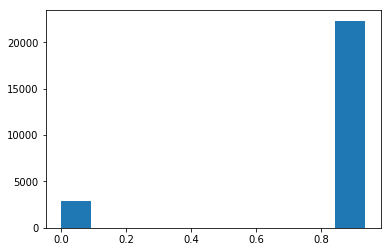

In [437]:
import matplotlib.pyplot as plt
plt.hist(temp)
plt.show()

In [438]:
gen_model7.learned_lf_stats()

Accuracy  Coverage  Precision    Recall
0  0.932726    0.8012    0.93273  0.741922

#### Evaluating Generative model

In [439]:
L_dev7 = labeler7.apply_existing(split=1)

Clearing existing...
Running UDF...
[========================================] 100%



In [440]:
tp, fp, tn, fn = gen_model7.error_analysis(session, L_dev7, L_gold_dev)

Scores (Un-adjusted)
Pos. class accuracy: 0.966
Neg. class accuracy: 1.0
Precision            1.0
Recall               0.966
F1                   0.983
----------------------------------------
TP: 113 | FP: 0 | TN: 14 | FN: 4



#### Discriminative model 

In [442]:
from snorkel.learning.disc_models.rnn import reRNN

train_kwargs = {
    'lr':         0.001,
    'dim':        100,
    'n_epochs':   10,
    'dropout':    0.25,
    'print_freq': 1,
    'batch_size': 128,
    'max_sentence_length': 100
}

lstm7 = reRNN(seed=1701, n_threads=2)
%time lstm7.train(train_cands, train_marginals7, X_dev=dev_cands, Y_dev=L_gold_dev, **train_kwargs)

[reRNN] Training model
[reRNN] n_train=25217  #epochs=10  batch size=128
[reRNN] Epoch 0 (39.14s)	Average loss=0.323668	Dev F1=98.26
[reRNN] Epoch 1 (79.66s)	Average loss=0.227944	Dev F1=98.26
[reRNN] Epoch 2 (123.66s)	Average loss=0.225274	Dev F1=98.26
[reRNN] Epoch 3 (167.05s)	Average loss=0.224938	Dev F1=98.70
[reRNN] Epoch 4 (205.70s)	Average loss=0.224763	Dev F1=97.82
[reRNN] Epoch 5 (244.43s)	Average loss=0.224651	Dev F1=97.82
[reRNN] Epoch 6 (282.26s)	Average loss=0.224735	Dev F1=98.26
[reRNN] Epoch 7 (321.58s)	Average loss=0.224644	Dev F1=97.82
[reRNN] Epoch 8 (364.30s)	Average loss=0.224567	Dev F1=97.82
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 9 (403.70s)	Average loss=0.224561	Dev F1=97.82
[reRNN] Training done (403.79s)
INFO:tensorflow:Restoring parameters from checkpoints/reRNN/reRNN-8
[reRNN] Loaded model <reRNN>
CPU times: user 13min 7s, sys: 40.2 s, total: 13min 47s
Wall time: 6min 48s


#### Evaluating Discriminative model 

In [443]:
p, r, f1 = lstm7.score(test_cands, L_gold_test)
print("Prec: {0:.3f}, Recall: {1:.3f}, F1 Score: {2:.3f}".format(p, r, f1))

Prec: 1.000, Recall: 0.982, F1 Score: 0.991


In [444]:
tp, fp, tn, fn = lstm7.error_analysis(session, test_cands, L_gold_test)

Scores (Un-adjusted)
Pos. class accuracy: 0.982
Neg. class accuracy: 1.0
Precision            1.0
Recall               0.982
F1                   0.991
----------------------------------------
TP: 856 | FP: 0 | TN: 103 | FN: 16



### Saving the LSTM model 

In [524]:
lstm7.save("LSTM7")

[reRNN] Model saved as <LSTM7>


# 8. Overly Robust Covariance Estimation

In [446]:
def LF_Good_Measurement8(c):
    val = c.number1.get_attrib_tokens()
    if float(val[0])<=270.6:
        return 1
    else:
        return 0
LFs8 = [ LF_Good_Measurement8] 

#### Applying labelling function to the train set

In [447]:
from snorkel.annotations import LabelAnnotator
import numpy as np

labeler8 = LabelAnnotator(lfs=LFs8)

np.random.seed(1701)
%time L_train8 = labeler8.apply(split=0)
L_train8

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 1min 24s, sys: 977 ms, total: 1min 25s
Wall time: 1min 27s


<25217x1 sparse matrix of type '<type 'numpy.int64'>'
	with 11730 stored elements in Compressed Sparse Row format>

In [448]:
L_train8.lf_stats(session)

j  Coverage  Overlaps  Conflicts
LF_Good_Measurement8  0  0.465162       0.0        0.0

#### Applying labelling function to dev set

In [449]:
np.random.seed(1701)

%time L_dev8 = labeler8.apply_existing(split=1, lfs=LFs8, parallelism=1)
print L_dev8.shape
L_dev8

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 731 ms, sys: 43.8 ms, total: 775 ms
Wall time: 825 ms
(131, 1)


<131x1 sparse matrix of type '<type 'numpy.int64'>'
	with 56 stored elements in Compressed Sparse Row format>

In [450]:
L_dev8.lf_stats(session, labels=L_gold_dev.toarray().ravel())

j  Coverage  Overlaps  Conflicts  TP  FP  FN  TN  \
LF_Good_Measurement8  0  0.427481       0.0        0.0  56   0   0   0   

                      Empirical Acc.  
LF_Good_Measurement8             1.0

#### Training Generative Model 

In [451]:
from snorkel.learning import GenerativeModel

gen_model8 = GenerativeModel()
gen_model8.train(L_train8, epochs=100, decay=0.95, step_size=0.1 / L_train8.shape[0], reg_param=1e-6)

Inferred cardinality: 2


In [452]:
gen_model8.weights.lf_accuracy

array([0.4287606])

In [453]:
train_marginals8 = gen_model8.marginals(L_train8)
train_marginals8

array([0.7021425, 0.5      , 0.7021425, ..., 0.7021425, 0.7021425,
       0.7021425])

### Assigning probabilities to noisy data 

In [467]:
new_marginals8 = train_marginals8

val = 270.6
for i in range(len(train_marginals8)):
    if train_marginals8[i]==0.5:
        diff = float(train_cands[i].number1.get_attrib_tokens()[0])-val
        #print(diff)
        new_marginals8[i] = badness(diff)

In [468]:
train_marginals8[:300]

array([0.7021425, 0.3      , 0.7021425, 0.01     , 0.01     , 0.01     ,
       0.7021425, 0.7021425, 0.7021425, 0.01     , 0.25     , 0.45     ,
       0.7021425, 0.7021425, 0.35     , 0.7021425, 0.7021425, 0.4      ,
       0.4      , 0.7021425, 0.7021425, 0.45     , 0.1      , 0.01     ,
       0.7021425, 0.7021425, 0.3      , 0.7021425, 0.7021425, 0.7021425,
       0.4      , 0.45     , 0.45     , 0.3      , 0.01     , 0.01     ,
       0.2      , 0.7021425, 0.35     , 0.7021425, 0.01     , 0.01     ,
       0.35     , 0.7021425, 0.7021425, 0.7021425, 0.7021425, 0.7021425,
       0.7021425, 0.35     , 0.15     , 0.25     , 0.7021425, 0.4      ,
       0.4      , 0.7021425, 0.4      , 0.45     , 0.45     , 0.7021425,
       0.35     , 0.7021425, 0.4      , 0.45     , 0.45     , 0.35     ,
       0.7021425, 0.35     , 0.01     , 0.01     , 0.45     , 0.01     ,
       0.4      , 0.4      , 0.4      , 0.35     , 0.35     , 0.01     ,
       0.4      , 0.01     , 0.45     , 0.7021425, 

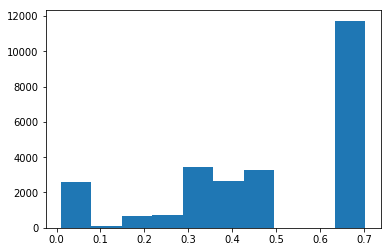

In [469]:
import matplotlib.pyplot as plt
plt.hist(train_marginals8)
plt.show()

In [470]:
gen_model8.learned_lf_stats()

Accuracy  Coverage  Precision    Recall
0  0.698146    0.6904   0.703002  0.483076

#### Evaluating Generative model

In [473]:
tp, fp, tn, fn = gen_model8.error_analysis(session, L_dev8, L_gold_dev)

Scores (Un-adjusted)
Pos. class accuracy: 0.479
Neg. class accuracy: 1.0
Precision            1.0
Recall               0.479
F1                   0.647
----------------------------------------
TP: 56 | FP: 0 | TN: 14 | FN: 61



#### Discriminative model 

In [474]:
from snorkel.learning.disc_models.rnn import reRNN

train_kwargs = {
    'lr':         0.001,
    'dim':        100,
    'n_epochs':   10,
    'dropout':    0.25,
    'print_freq': 1,
    'batch_size': 128,
    'max_sentence_length': 100
}

lstm8 = reRNN(seed=1701, n_threads=2)
%time lstm8.train(train_cands, train_marginals8, X_dev=dev_cands, Y_dev=L_gold_dev, **train_kwargs)

[reRNN] Training model
[reRNN] n_train=25217  #epochs=10  batch size=128
[reRNN] Epoch 0 (39.26s)	Average loss=0.597168	Dev F1=63.95
[reRNN] Epoch 1 (80.73s)	Average loss=0.568406	Dev F1=63.95
[reRNN] Epoch 2 (122.09s)	Average loss=0.566839	Dev F1=63.95
[reRNN] Epoch 3 (162.95s)	Average loss=0.566571	Dev F1=63.95
[reRNN] Epoch 4 (202.35s)	Average loss=0.566493	Dev F1=63.95
[reRNN] Epoch 5 (244.34s)	Average loss=0.566512	Dev F1=63.95
[reRNN] Epoch 6 (285.94s)	Average loss=0.566491	Dev F1=63.95
[reRNN] Epoch 7 (327.37s)	Average loss=0.566460	Dev F1=63.95
[reRNN] Epoch 8 (368.35s)	Average loss=0.566466	Dev F1=63.95
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 9 (410.02s)	Average loss=0.566424	Dev F1=63.95
[reRNN] Training done (410.15s)
INFO:tensorflow:Restoring parameters from checkpoints/reRNN/reRNN-8
[reRNN] Loaded model <reRNN>
CPU times: user 13min 17s, sys: 42.2 s, total: 14min
Wall time: 6min 54s


#### Evaluating Discriminative model 

In [475]:
p, r, f1 = lstm8.score(test_cands, L_gold_test)
print("Prec: {0:.3f}, Recall: {1:.3f}, F1 Score: {2:.3f}".format(p, r, f1))

Prec: 1.000, Recall: 0.531, F1 Score: 0.694


In [476]:
tp, fp, tn, fn = lstm8.error_analysis(session, test_cands, L_gold_test)

Scores (Un-adjusted)
Pos. class accuracy: 0.531
Neg. class accuracy: 1.0
Precision            1.0
Recall               0.531
F1                   0.694
----------------------------------------
TP: 463 | FP: 0 | TN: 103 | FN: 409



### Saving the LSTM model 

In [523]:
lstm8.save("LSTM8")

[reRNN] Model saved as <LSTM8>


# 9. Isolation Forest

In [477]:
def LF_Good_Measurement9(c):
    val = c.number1.get_attrib_tokens()
    if float(val[0])<=269.5:
        return 1
    else:
        return 0
LFs9 = [ LF_Good_Measurement9] 

#### Applying labelling function to the train set

In [ ]:
from snorkel.annotations import LabelAnnotator
import numpy as np

labeler9 = LabelAnnotator(lfs=LFs9)

np.random.seed(1701)
%time L_train9 = labeler9.apply_existing(split=0)
L_train9

In [ ]:
L_train9.lf_stats(session)

#### Applying labelling function to dev set

In [ ]:
np.random.seed(1701)

%time L_dev9 = labeler9.apply_existing(split=1, lfs=LFs9, parallelism=1)
print L_dev9.shape
L_dev9

In [ ]:
L_dev9.lf_stats(session, labels=L_gold_dev.toarray().ravel())

#### Training Generative Model 

In [ ]:
from snorkel.learning import GenerativeModel

gen_model9 = GenerativeModel()
gen_model9.train(L_train9, epochs=100, decay=0.95, step_size=0.1 / L_train9.shape[0], reg_param=1e-6)

In [ ]:
gen_model9.weights.lf_accuracy

In [ ]:
train_marginals9 = gen_model9.marginals(L_train9)
train_marginals9

#### Assigning probabilities to noisy data 

In [517]:
temp9 = train_marginals9

val = 269.5
for i in range(len(train_marginals9)):
    if train_marginals9[i]==0.5:
        diff = float(train_cands[i].number1.get_attrib_tokens()[0])-val
        #print(diff)
        temp9[i] = badness(diff)

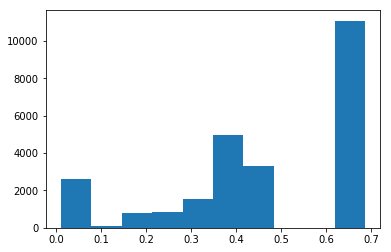

In [518]:
import matplotlib.pyplot as plt
plt.hist(train_marginals9)
plt.show()

In [ ]:
gen_model9.learned_lf_stats()

#### Evaluating Generative model

In [ ]:
tp, fp, tn, fn = gen_model9.error_analysis(session, L_dev9, L_gold_dev)

#### Discriminative model 

In [519]:
from snorkel.learning.disc_models.rnn import reRNN

train_kwargs = {
    'lr':         0.001,
    'dim':        100,
    'n_epochs':   10,
    'dropout':    0.25,
    'print_freq': 1,
    'batch_size': 128,
    'max_sentence_length': 100
}

lstm9 = reRNN(seed=1701, n_threads=2)
%time lstm9.train(train_cands, train_marginals9, X_dev=dev_cands, Y_dev=L_gold_dev, **train_kwargs)

[reRNN] Training model
[reRNN] n_train=25217  #epochs=10  batch size=128
[reRNN] Epoch 0 (39.57s)	Average loss=0.600619	Dev F1=67.80
[reRNN] Epoch 1 (80.23s)	Average loss=0.573847	Dev F1=59.04
[reRNN] Epoch 2 (119.57s)	Average loss=0.572350	Dev F1=59.04
[reRNN] Epoch 3 (157.10s)	Average loss=0.571826	Dev F1=59.04
[reRNN] Epoch 4 (197.51s)	Average loss=0.571803	Dev F1=59.04
[reRNN] Epoch 5 (238.97s)	Average loss=0.571743	Dev F1=59.04
[reRNN] Epoch 6 (276.43s)	Average loss=0.571732	Dev F1=59.04
[reRNN] Epoch 7 (313.79s)	Average loss=0.571733	Dev F1=59.04
[reRNN] Epoch 8 (357.68s)	Average loss=0.571739	Dev F1=59.04
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 9 (398.63s)	Average loss=0.571721	Dev F1=59.04
[reRNN] Training done (398.73s)
INFO:tensorflow:Restoring parameters from checkpoints/reRNN/reRNN-8
[reRNN] Loaded model <reRNN>
CPU times: user 12min 48s, sys: 42.8 s, total: 13min 30s
Wall time: 6min 45s


#### Evaluating Discriminative model 

In [520]:
p, r, f1 = lstm9.score(test_cands, L_gold_test)
print("Prec: {0:.3f}, Recall: {1:.3f}, F1 Score: {2:.3f}".format(p, r, f1))

Prec: 1.000, Recall: 0.507, F1 Score: 0.673


In [521]:
tp, fp, tn, fn = lstm9.error_analysis(session, test_cands, L_gold_test)

Scores (Un-adjusted)
Pos. class accuracy: 0.507
Neg. class accuracy: 1.0
Precision            1.0
Recall               0.507
F1                   0.673
----------------------------------------
TP: 442 | FP: 0 | TN: 103 | FN: 430



### Saving the LSTM model 

In [522]:
lstm9.save("LSTM9")

[reRNN] Model saved as <LSTM9>


<b>========================================XXXX===============================================

# Testing the performance of the model on real time data

In [1]:
import os
from snorkel import SnorkelSession
session = SnorkelSession()

In [2]:
from snorkel.parser import TSVDocPreprocessor
    
doc_preprocessor = TSVDocPreprocessor('/users/anirudhmuthukumar/downloads/snorkel-master/myscripts/data/Labeled RTT.tsv')

In [3]:
from snorkel.parser.spacy_parser import Spacy
from snorkel.parser import CorpusParser

corpus_parser = CorpusParser(parser=Spacy())
%time c = corpus_parser.apply(doc_preprocessor)

Clearing existing...
Running UDF...
CPU times: user 19.7 s, sys: 498 ms, total: 20.1 s
Wall time: 20.4 s


In [4]:
from snorkel.models import Document, Sentence

print("Documents:", session.query(Document).count())
print("Sentences:", session.query(Sentence).count())

('Documents:', 15000)
('Sentences:', 15000)


### Extracting Document name and sentences from each document

In [5]:
docs = session.query(Document).order_by(Document.name).all()

test_sents  = set()

for i, doc in enumerate(docs):
    for s in doc.sentences:
        test_sents.add(s)
                
len(test_sents)

15000

Sample format of the sentences 

In [6]:
import itertools 

small = set(itertools.islice(test_sents, 100))

### Defining candidate subclass 
`Candidates` are basically potential mentions found in text in which we are interested in for training the model.

In [7]:
from snorkel.models import candidate_subclass

Person = candidate_subclass('Person', ['person'])
Values = candidate_subclass('test', ['number1', 'number2'])

In [8]:
from snorkel.candidates import Ngrams, CandidateExtractor
from snorkel.matchers import RegexMatchEach

ngrams         = Ngrams(n_max=1)
number_matcher = RegexMatchEach(rgx='^[0-9]+.[0-9]+$')
cand_extractor = CandidateExtractor(Values, [ngrams, ngrams], [number_matcher, number_matcher])

### Extracting candidates from the sentences using `CandidateExtractor`

In [9]:
%time cand_extractor.apply(small, split=7)
print("Number of candidates:", session.query(Values).filter(Values.split == 7).count())

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 515 ms, sys: 42.9 ms, total: 558 ms
Wall time: 616 ms
('Number of candidates:', 100)


In [11]:
cands = session.query(Values).filter(Values.split ==7).all()

### Considering only 300 observation for simplicity

In [12]:
len(cands)

100

### Annotating the testing candidates  

In [13]:
from snorkel.viewer import SentenceNgramViewer

SentenceNgramViewer(cands, session, n_per_page=1)

<IPython.core.display.Javascript object>

U2VudGVuY2VOZ3JhbVZpZXdlcihjaWRzPVtbWzE3XV0sIFtbNV1dLCBbWzc3XV0sIFtbNDJdXSwgW1s2OV1dLCBbWzI5XV0sIFtbOThdXSwgW1s5M11dLCBbWzg1XV0sIFtbNzVdXSwgW1s3OF3igKY=


In [672]:
gold_test = load_gold_labels(session, annotator_name=os.environ['USER'], split=5)
gold_test

InvalidRequestError: This Session's transaction has been rolled back due to a previous exception during flush. To begin a new transaction with this Session, first issue Session.rollback(). Original exception was: (sqlite3.IntegrityError) UNIQUE constraint failed: stable_label.context_stable_ids, stable_label.annotator_name [SQL: u'INSERT INTO stable_label (context_stable_ids, annotator_name, split, value) VALUES (?, ?, ?, ?)'] [parameters: (u'1681::span:0:4~~1681::span:6:10', u'anirudhmuthukumar', 5, 1)] (Background on this error at: http://sqlalche.me/e/gkpj)

In [674]:
session.rollback()

/anaconda2/lib/python2.7/site-packages/sqlalchemy/orm/session.py:521: SAWarning: Session's state has been changed on a non-active transaction - this state will be discarded.
  "Session's state has been changed on "


### Loading the deep neural network model

In [631]:
model = reRNN(seed=1701, n_threads=2)

In [650]:
model.load("LSTM1")

INFO:tensorflow:Restoring parameters from checkpoints/LSTM1/LSTM1-0
[reRNN] Loaded model <LSTM1>


In [637]:
test_labels = np.load('data/Gold label.npy')

In [651]:
model.score(test_cands, test_labels)

(1.0, 0.00014814814814814815, 0.0002962524070508073)

In [ ]:
model.error_analysis(session, )